# Analyse des résultats

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np

from octantng.vanilla.data import VanillaOrf
from octantng.vanilla.data.ges_table_dir import GesTableDir
from octantng.vanilla.data.table import TableMeasure
from matplotlib.colors import LinearSegmentedColormap
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
GES_TABLE_DIR="/data/SSB_ETU/S6JTEX/DSC"
os.environ['OCE_DATA']="/data/SUPPORT/DONNEES/"
GesTableDir().set_value(GES_TABLE_DIR)

TABLE_NAME = "TABLE_C_S6A_LR_B_S6JTEX_TEST"
ORF_NAME = "C_S6A_LR_ORF"

orf = VanillaOrf(ORF_NAME)
cycle_dates_deb = orf.cycle_dates(42)
cycle_dates_end = orf.cycle_dates(79)

print(cycle_dates_deb)
print(cycle_dates_end)

(numpy.datetime64('2021-12-29T05:10:53.000000'), numpy.datetime64('2022-01-08T03:09:23.000000'))
(numpy.datetime64('2022-12-31T02:16:19.000000'), numpy.datetime64('2023-01-10T00:14:49.000000'))


In [3]:

table = TableMeasure(TABLE_NAME)
fields={
    "longitude": "LONGITUDE",
    "latitude": "LATITUDE",
    #"ssh_etu": "100*(SEA_SURFACE_HEIGHT_ANOMALY.ALTI + MEAN_SEA_SURFACE.MODEL.CNESCLS + SEA_STATE_BIAS.ALTI  - SSB_2D_REF)",
    #"ssh_ref": "100*(SEA_SURFACE_HEIGHT_ANOMALY.ALTI + MEAN_SEA_SURFACE.MODEL.CNESCLS)"
    "ssh_etu": "100*(SEA_SURFACE_HEIGHT_ANOMALY.ALTI + MEAN_SEA_SURFACE.MODEL.CNESCLS + SEA_STATE_BIAS.ALTI  - SSB_2D_PC1_PC2)",
    "ssh_ref": "100*(SEA_SURFACE_HEIGHT_ANOMALY.ALTI + MEAN_SEA_SURFACE.MODEL.CNESCLS + SEA_STATE_BIAS.ALTI  - SSB_2D_REF)"
    #"ssh_etu": "100*(SEA_SURFACE_HEIGHT.ALTI.INTERP- IONOSPHERIC_CORRECTION.ALTI.FILTR - DRY_TROPOSPHERIC_CORRECTION.MODEL - WET_TROPOSPHERIC_CORRECTION.RAD - SSB_2D_PC1_PC2 - SOLID_EARTH_TIDE_HEIGHT.MODEL - OCEAN_TIDE_HEIGHT.MODEL.FES- OCEAN_TIDE_NEQ_LP.MODEL - INTERNAL_TIDE.MODEL - POLE_TIDE_HEIGHT.MODEL- DYNAMICAL_ATMOSPHERIC_CORRECTION.MODEL)",
    #"ssh_ref": "100*(SEA_SURFACE_HEIGHT.ALTI.INTERP- IONOSPHERIC_CORRECTION.ALTI.FILTR - DRY_TROPOSPHERIC_CORRECTION.MODEL - WET_TROPOSPHERIC_CORRECTION.RAD - SEA_STATE_BIAS.ALTI  - SOLID_EARTH_TIDE_HEIGHT.MODEL - OCEAN_TIDE_HEIGHT.MODEL.FES- OCEAN_TIDE_NEQ_LP.MODEL - INTERNAL_TIDE.MODEL - POLE_TIDE_HEIGHT.MODEL- DYNAMICAL_ATMOSPHERIC_CORRECTION.MODEL)"
}

### Toutes les données valides ####
data = table.read_values_as_dataset(fields, cycle_dates_deb[0], cycle_dates_end[1], select="FLAG_VAL.ALTI == 0  && bnd(-0.5,SSB_2D_PC1_PC2,0) && bnd(-0.5,SSB_2D_REF,0)" )#"(FLAG_VAL.ALTI ==0 && bnd(-0.5, SSB_TEMP_1, 0.1) && bnd(-0.5, SSB_REF,0.1))") #"FLAG_VAL.ALTI==0 && NE_DV(SSB_CORRECTION_PRINCIPAL_COMPONENT_1) && NE_DV(SSB_CORRECTION_PRINCIPAL_COMPONENT_1) && NE_DV(T02_ERA5)  && NE_DV(ORBITAL_VELOCITY_STD) && NE_DV(VELOCITY_STOKES_DRIFT_PROJ_ERA5)")

### SL2 #######
#data = table.read_values_as_dataset(fields, cycle_dates_deb[0], cycle_dates_end[1], select="FLAG_VAL.ALTI==0 && BATHYMETRY.MODEL < -1000 && OCEANIC_VARIABILITY < 0.2 && ABS(LATITUDE) < 60")
#CLIP_SSH = IIF(FLAG_VAL.ALTI==0 && (BATHYMETRY.MODEL<-1000) && bnd(1,OCEANIC_BASIN_NUMBER,5) && bnd(-60,LATITUDE,60) && bnd(0,OCEANIC_VARIABILITY,0.15) && bnd_strict(0.0,SSB_CORRECTION_PRINCIPAL_COMPONENT_1 + 8.0, 20.75) && bnd_strict(0.0,SSB_CORRECTION_PRINCIPAL_COMPONENT_2 + 5.0, 11.75),SSB_CORRECTION_PRINCIPAL_COMPONENT_1 + 8.0,DV)

table.close()

In [4]:
from casys import CasysPlot
from casys import Field
from casys.readers import CLSTableReader, MultiReader
from casys import CasysPlot, DateHandler, Field, NadirData, PlotParams

reader = CLSTableReader(name="TABLE_C_S6A_LR_B_S6JTEX_TEST", date_start=cycle_dates_deb[0], date_end=cycle_dates_end[1])

ad_ssb = NadirData(
        source= reader,
        orf=orf,
        #select_clip="(FLAG_VAL.ALTI ==0 && bnd(-0.5, SSB_TEMP_1, 0.1) && bnd(-0.5, SSB_REF,0.1)) && NE_DV(SSB_CORRECTION_PRINCIPAL_COMPONENT_1) && NE_DV(SSB_CORRECTION_PRINCIPAL_COMPONENT_2) && NE_DV(T02_ERA5)  && NE_DV(ORBITAL_VELOCITY_STD) && NE_DV(VELOCITY_STOKES_DRIFT_PROJ_ERA5)",
        select_clip="FLAG_VAL.ALTI == 0  && bnd(-0.5,SSB_2D_PC1_PC2,0) && bnd(-0.5,SSB_2D_REF,0)",
        #select_clip="(FLAG_VAL.ALTI ==0 && bnd(-0.5, SSB_TEMP_1, 0.1) && bnd(-0.5, SSB_REF,0.1))",
        time="time",
        longitude="LONGITUDE",
        latitude="LATITUDE",
)

ssb_corr = Field(
    name="ssb_corr",
    source="SSB_2D_PC1_PC2",
    unit="m",
)

ad_ssb.add_histogram(
    name="Histogram SSB S6A cycles 42 to 79",
    x=ssb_corr,
    res_x = (-0.5, 0.1, 0.001)
)


ssb_pc = Field(
    name="ssb_pc",
    source="IIF(FLAG_VAL.ALTI==0, SSB_2D_PC1_PC2, DV)",
    unit="m",
)
ssb_ref = Field(
    name="ssb_ref",
    source="IIF(FLAG_VAL.ALTI==0, SSB_REF, DV)",
    unit="m",
)

ad_ssb.add_scatter(
    name="Scatter SSB_REF / SSB_PC, S6A cycles 42 to 79",
    x=ssb_ref,
    y=ssb_pc,
    res_x=(-0.5, 0.1, 0.001),
    res_y=(-0.5, 0.1, 0.001),
)

ad_ssb.compute()


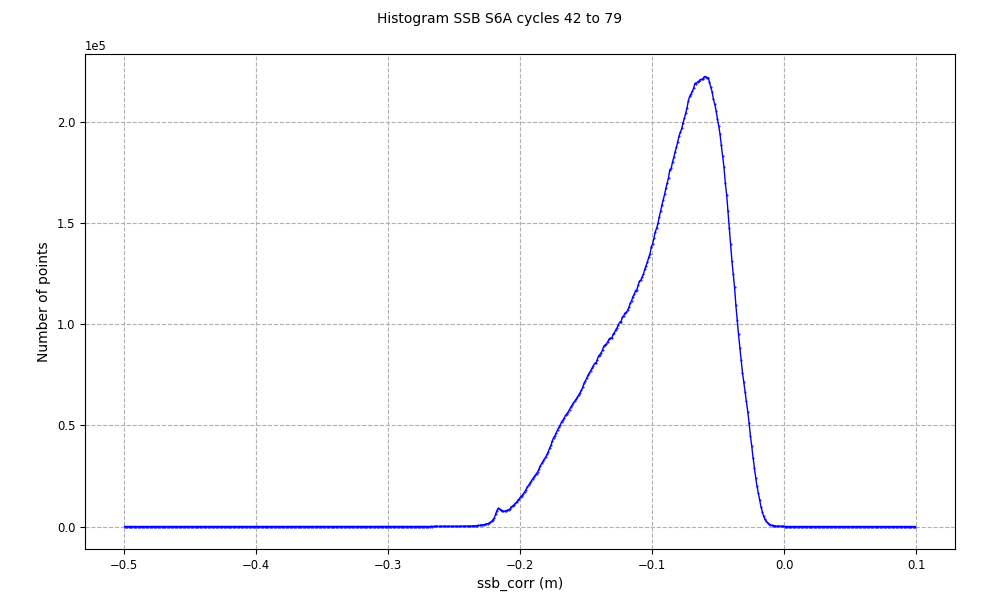

In [5]:
plot_hist = CasysPlot(data=ad_ssb, data_name="Histogram SSB S6A cycles 42 to 79", plot_params=PlotParams(grid=True, bars=False),)
plot_hist.show()

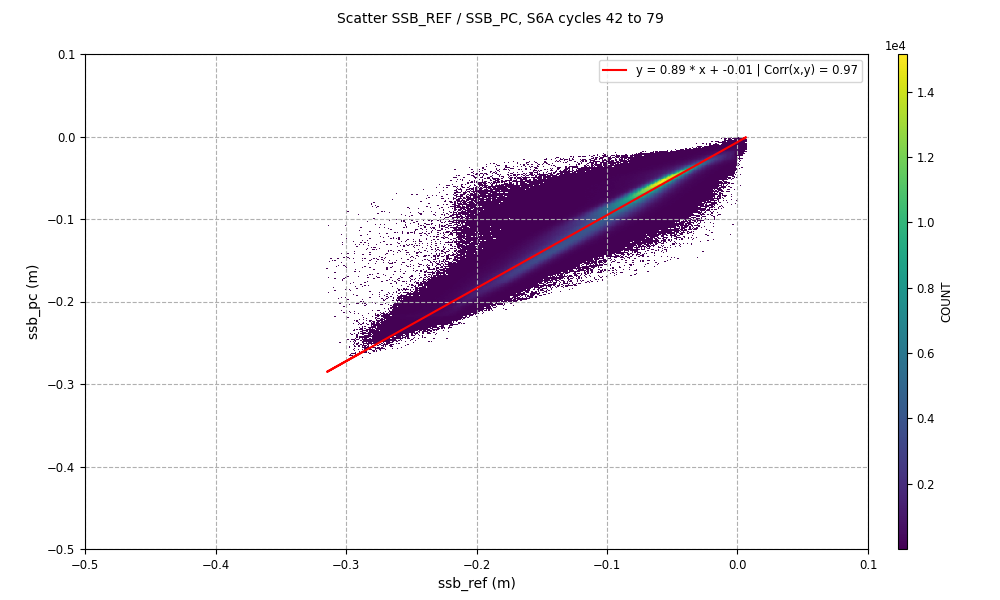

In [6]:
plot_scatter = CasysPlot(
    data=ad_ssb,
    data_name="Scatter SSB_REF / SSB_PC, S6A cycles 42 to 79",
    plot_params=PlotParams(grid=True, show_reg=True),
)

plot_scatter.show()

In [7]:
#RECHERCHE DES INTERSECTIONS

from octantng.algo.geodesic.crossovers import CrossoversBuilder

cro_builder = CrossoversBuilder(dset=data, lon_name="longitude", lat_name="latitude")
cro_builder.find_intersections()

(array([18.63816029, 19.77198113, 19.78372123, ..., 87.88341809,
        73.70811305, 59.5336399 ]),
 array([-66.13902287, -66.12184153, -66.12161557, ..., -58.3243378 ,
        -63.09796935, -65.43645955]))

In [8]:
#INTERPOLATION DES VARIABLES SUR LES POINTS DE CROSSOVER

from octantng.algo.geodesic.crossovers import CroTimeVar, CroVar, CroDescr
time_var = CroTimeVar(name="time", max_delta=np.timedelta64(10, "D"))

#ssb_corr = CroVar(name="ssb_corr",mode="smooth")
ssh_etu = CroVar(name="ssh_etu",mode="smooth")
ssh_ref = CroVar(name="ssh_ref",mode="smooth")
variables = {"ssh_etu": ssh_etu, "ssh_ref":ssh_ref}

crossovers = cro_builder.interpolate_variables(CroDescr(time_var, variables))


In [9]:
#CALCULS DES DIFFERENCES AU CROSSOVER

diff = crossovers.compute_differences()

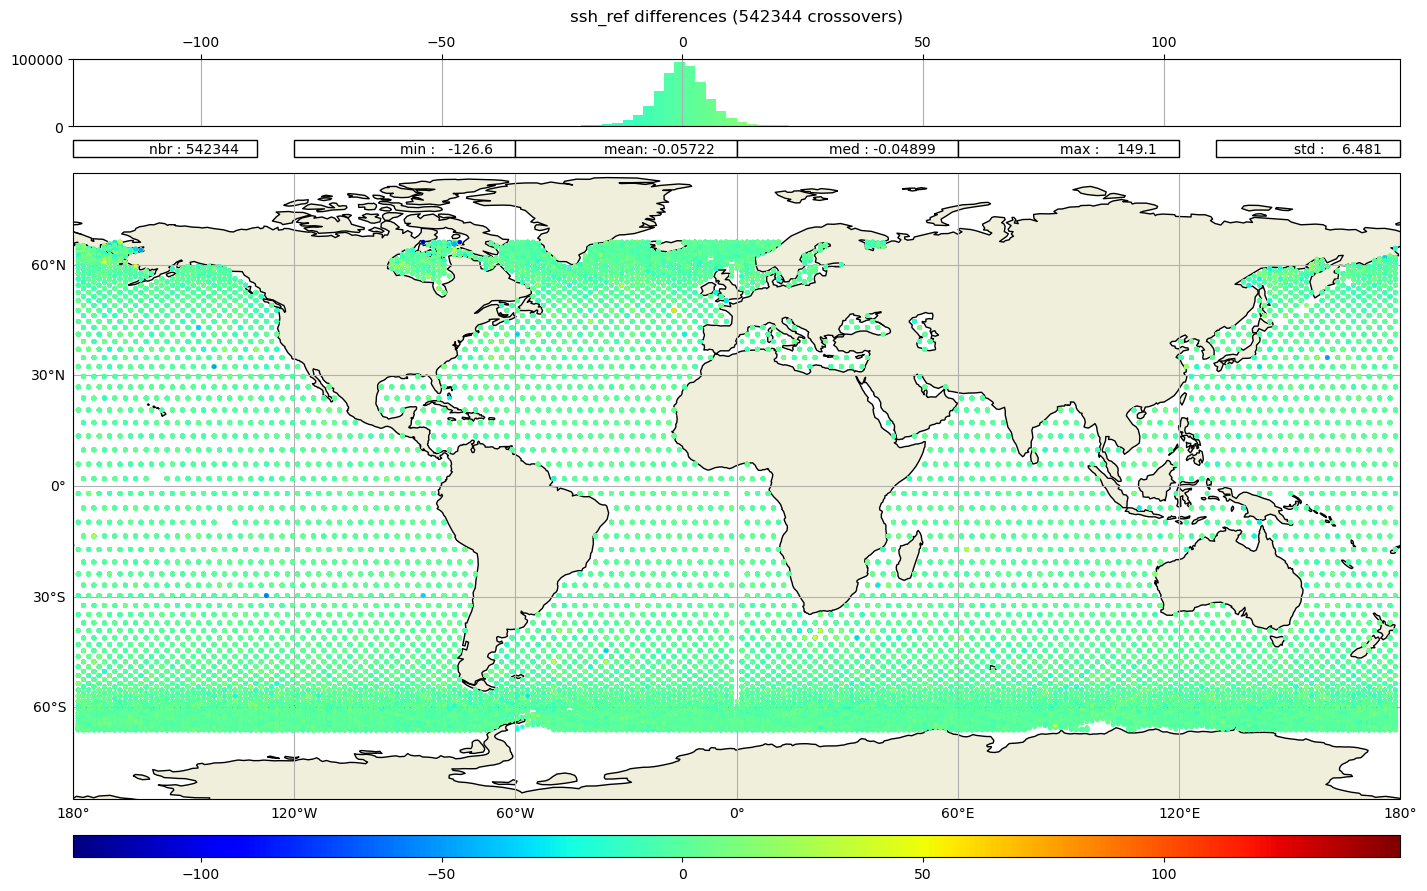

In [10]:
crossovers.show_differences(diff.drop(["ssh_etu"]))

In [11]:
#CHARGEMENT DES CROSSOVERS DANS UN NADIR DATA

from casys import NadirData, DateHandler
from casys.readers import ZarrDatasetReader
import os

ad_ds = NadirData(
    source = diff,
    date_start=cycle_dates_deb[0],
    date_end=cycle_dates_end[1],
    orf=ORF_NAME,
    time="time",
    longitude="lon",
    latitude="lat",
    diag_overwrite=True,
    
)


In [12]:
diff

<xarray.Dataset> Size: 27MB
Dimensions:     (time: 555139)
Coordinates:
  * time        (time) datetime64[ns] 4MB 2022-01-01T04:23:11.201131977 ... 2...
    lon         (time) float64 4MB 19.84 21.28 22.67 24.09 ... 87.88 73.71 59.53
    lat         (time) float64 4MB -66.12 -66.09 -66.04 ... -58.32 -63.1 -65.44
Data variables:
    time_delta  (time) timedelta64[ns] 4MB 5 days 22:23:53.314317363 ... -1 d...
    ssh_etu     (time) float64 4MB 2.164 -5.846 -0.2815 ... -4.118 1.225 -0.7743
    ssh_ref     (time) float64 4MB 3.679 -5.2 0.2025 ... -4.57 1.192 -0.1793

In [13]:
ad_ds.add_time_stat(name="var ssh_etu per day",
                    freq="cycle",
                    field=ad_ds.fields["ssh_etu"],
                    stats="var")

ad_ds.add_time_stat(name="var ssh_ref per day",
                    freq="cycle",
                    field=ad_ds.fields["ssh_ref"],
                    stats="var")
ad_ds.compute()

In [14]:
cp1 = CasysPlot(data=ad_ds, data_name="var ssh_etu per day", stat="var")
cp1.add_stat_bar()
cp2 = CasysPlot(data=ad_ds, data_name="var ssh_ref per day", stat="var")
cp2.add_stat_bar()

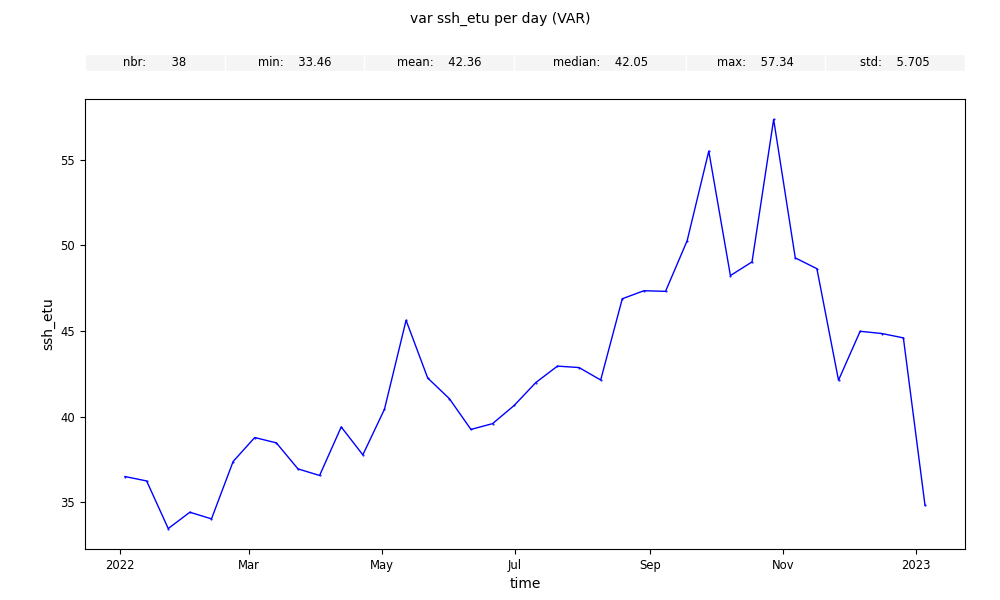

In [15]:
cp1.show()

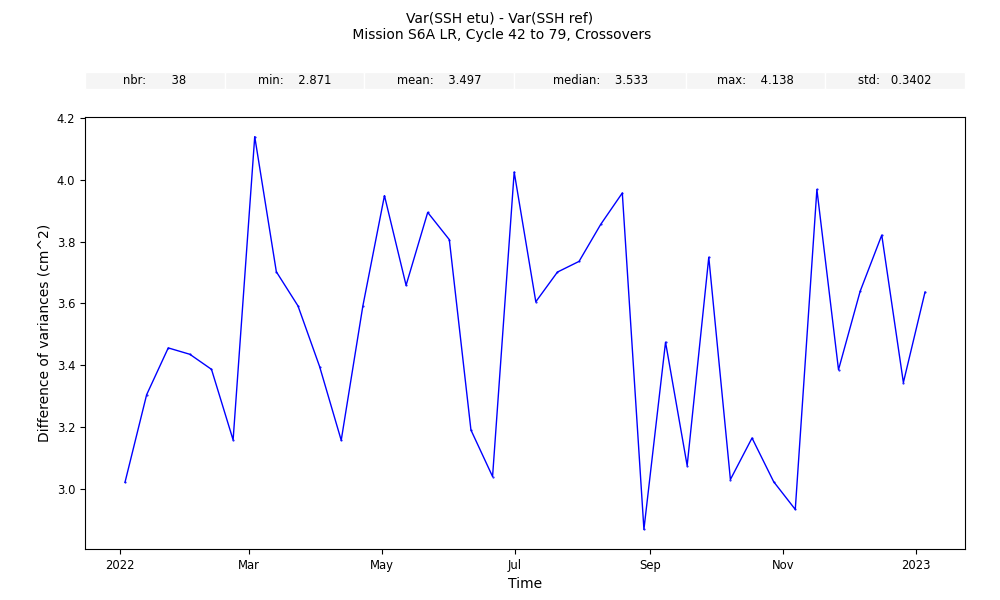

In [15]:
cp3 = cp1-cp2
cp3.set_title("Var(SSH etu) - Var(SSH ref)\n Mission S6A LR, Cycle 42 to 79, Crossovers")
cp3.set_xlabel("Time")
cp3.set_ylabel("Difference of variances (cm^2)")
cp3.show()

In [16]:
y = cp3.data["(ssh_etu - ssh_ref)"]
x = cp3.data.time

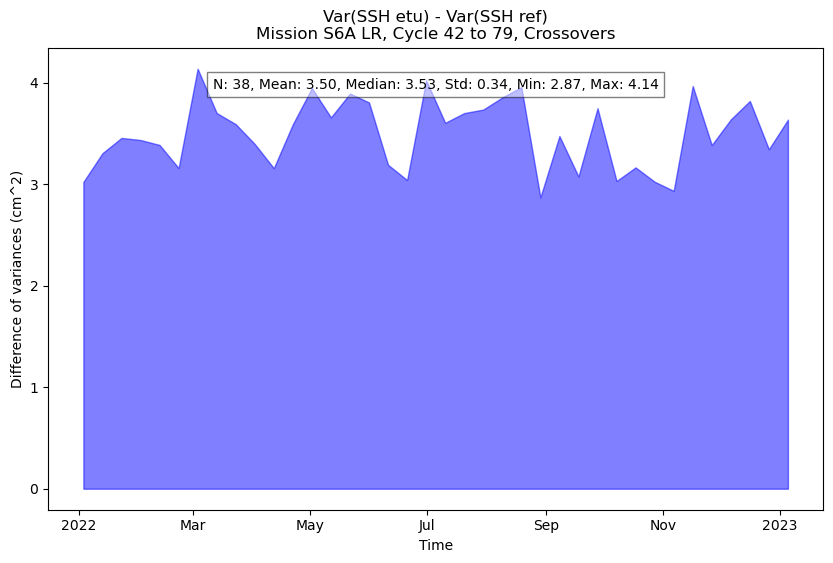

In [17]:
# Calcul des statistiques
mean_y = np.mean(y)
std_y = np.std(y)
min_y = np.min(y)
max_y = np.max(y)
median_y = np.median(y)
num_values = len(y)

# Création du graphique
plt.figure(figsize=(10, 6))
plt.fill_between(x, y, where=(y >= 0), interpolate=True, color='blue', alpha=0.5, label='Positive')
plt.fill_between(x, y, where=(y < 0), interpolate=True, color='green', alpha=0.5, label='Negative')
plt.xlabel('Time')
plt.ylabel('Difference of variances (cm^2)')
plt.title('Var(SSH etu) - Var(SSH ref)\nMission S6A LR, Cycle 42 to 79, Crossovers')

# Ajout de la barre de statistiques sous le titre
stats_text = (
    f'N: {num_values}, Mean: {mean_y:.2f}, Median: {median_y:.2f}, Std: {std_y:.2f}, Min: {min_y:.2f}, Max: {max_y:.2f}'
)
plt.text(0.5, 0.92, stats_text, ha='center', va='center', transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

plt.show()

In [18]:
#CALCUL DES STATS

ad_ds.add_geobox_stat(
    name = "SSH ETU",
    field = ad_ds.fields["ssh_etu"],
    stats=["var", "count"],
    res_lon= (-180,180,4),
    res_lat = (-60,60,4)
)
ad_ds.add_geobox_stat(
    name = "SSH REF",
    field = ad_ds.fields["ssh_ref"],
    stats=["var"],
    res_lon= (-180,180,4),
    res_lat = (-60,60,4)
)
ad_ds.compute()

In [19]:
ad_ds.fields["ssh_etu"]

Name,Description,Unit
ssh_etu,ssh_etu,unknown


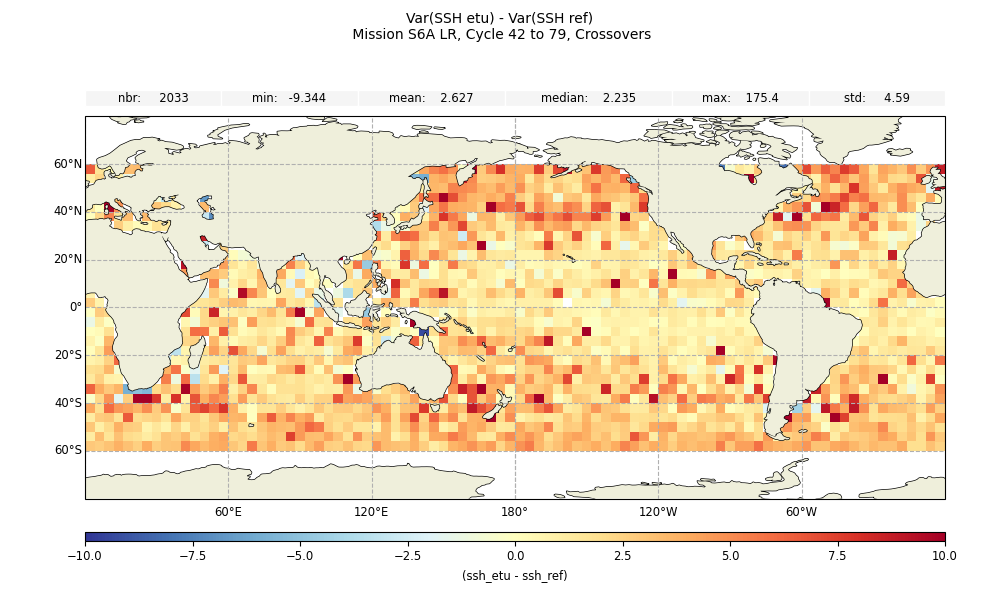

In [20]:
from casys import CasysPlot, PlotParams
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

plot_etu = CasysPlot(
    data=ad_ds,
    data_name="SSH ETU",
    stat="var",
    plot="box",
)

plot_ref = CasysPlot(
    data=ad_ds,
    data_name="SSH REF",
    stat="var",
    plot="box",
)


colors = ['#00008b','#0000c0','#0000f5','#002aff','#005fff','#0094ff','#00c9ff','#00feff','#56eac7','#a1c4ac','#adc79d','#cbed4e','#fffa00','#ffc500', '#ff9000','#ff5b00','#ff2600','#f10000','#bc0000','#870000']

# Créer la colormap personnalisée
cmap = LinearSegmentedColormap.from_list('custom_palette', colors, N=20)

COLOR_MAP = "RdYlBu_r"



plot_diff = plot_etu-plot_ref
plot_diff.set_plot_params(PlotParams(color_limits=(-10,10), y_limits = (-80,80), color_map=COLOR_MAP, grid = True, projection = ccrs.PlateCarree(central_longitude = 180), mask_land = True, fill_ocean = False))
plot_diff.add_stat_bar()
plot_diff.set_title("Var(SSH etu) - Var(SSH ref)\n Mission S6A LR, Cycle 42 to 79, Crossovers")
plot_diff.show()